이번 주차 과제는 간단한 이미지 데이터를 활용해 크기가 큰 데이터의 차원 축소를 진행하고 데이터의 라벨에 따라 클러스터링을 진행하는 과제입니다.

###필요한 모듈을 가져오세요.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from torch import nn
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MeanShift

# Image data 가져오기
https://www.kaggle.com/datasets/zalando-research/fashionmnist/data

###위 링크의 fashion mnist 데이터의 train dataset과 test dataset을 가져오세요.
(데이터의 용량이 크니 직접 다운로드 하지 말고 코드를 이용해 가져오도록 해보세요.)

In [14]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True
)

###데이터에 대한 정보들을 보여주세요.
(필수: 요약, 모양, 크기, 결측치 여부 등)

In [15]:
# train data 정보
print(train_data)
print(train_data.data.shape)
print(len(train_data))
print("결측치 수:", torch.isnan(train_data.data).sum().item())

# test data 정보
print(test_data)
print(test_data.data.shape)
print(len(test_data))
print("결측치 수:", torch.isnan(test_data.data).sum().item())

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
torch.Size([60000, 28, 28])
60000
결측치 수: 0
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
torch.Size([10000, 28, 28])
10000
결측치 수: 0


### Data중 첫 번째 이미지를 보여주세요.

In [16]:
train_data[0]

(<PIL.Image.Image image mode=L size=28x28>, 9)

# 이미지 전처리

### 이미지 데이터를 머신러닝에 이용하기 편한 형태로 바꾸어 합니다.
(torch model 사용 - tensor 형태로 바꾸기 등)

In [17]:
train = torch.tensor(train_data.data).float()
test = torch.tensor(test_data.data).float()

<ipython-input-17-3d217b87d35b>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train = torch.tensor(train_data.data).float()
<ipython-input-17-3d217b87d35b>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test = torch.tensor(test_data.data).float()


### 이미지 데이터는 픽셀 값이 0 - 255로 이루어져 있습니다. 이 값을 0 - 1까지의 값으로 normalize 해주세요.

In [18]:
train = train / 255.0
test = test / 255.0

### 추가적인 이미지 전처리를 진행해주세요.
(차원을 수정하는 것은 뒤의 문제에서 진행할 것이므로 여기에서 하지 마세요.)

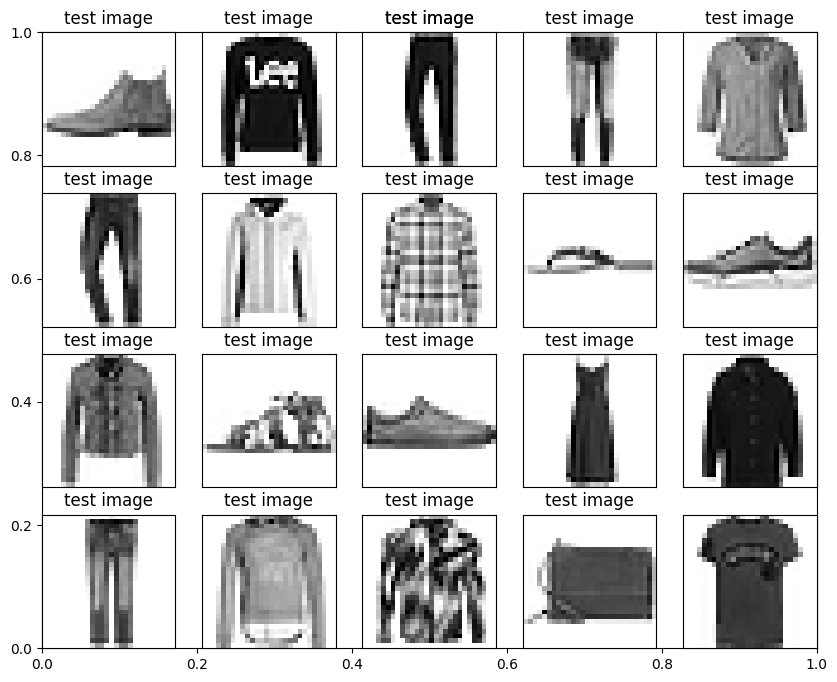

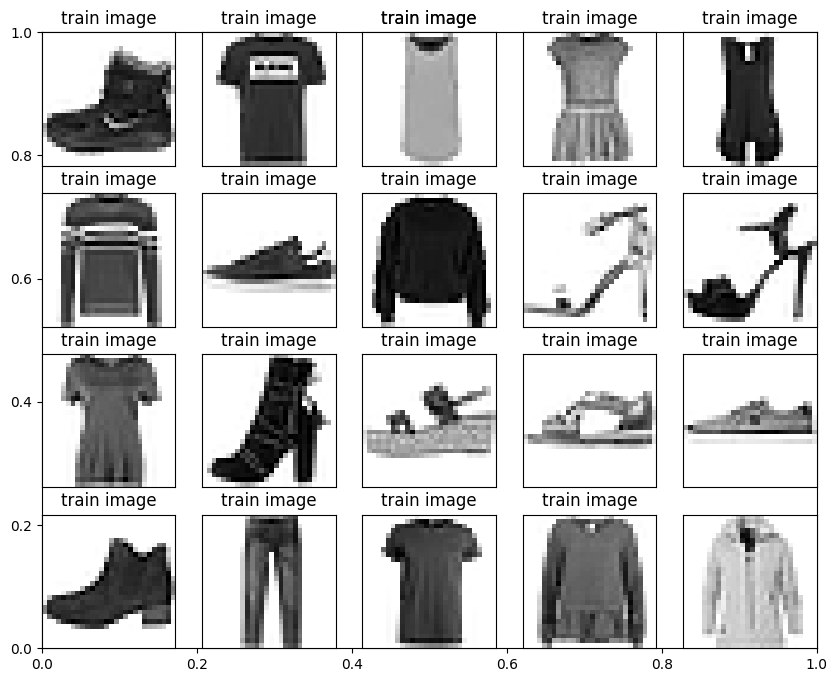

In [19]:
plt.figure(figsize=(10,8))
for i in range(20):
    plt.title('test image')
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test[i], cmap=plt.cm.binary)
plt.show()

plt.figure(figsize=(10,8))
for i in range(20):
    plt.title('train image')
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train[i], cmap=plt.cm.binary)
plt.show()

# 차원 축소
차원 축소란 고차원 데이터를 효율적으로 처리하기 위한 기법입니다.
### 그 중 대표적인 PCA와 t-sne에 대한 내용을 비교하여 아래에 적어주세요.

- PCA는 선형적 구조를 활용한 계산을 진행하여 더 쉽고 빠른 계산이 가능하나 차원 축소 시 데이터 간 변별력이 없어질 수 있다는 문제가 있다.
- t-sne 비선형적 구조를 활용한 계산을 진행하기에 곡선으로 이루어진 데이터 처리에 용이하다. 그래서, 차원을 축소해도 원본 데이터의 특성을 최대한 유지 가능하다는 장점이 있으나, 계산이 복잡하고 시간이 오래 걸린다는 문제가 있다.


## PCA

### 현재 데이터는 28*28로 784차원을 가지고 있습니다. PCA를 이용하여 데이터들을 가장 잘 설명하는 50개의 변수만으로 데이터를 변환하시오.

In [20]:
from sklearn.decomposition import PCA

re_train = train.reshape(train.shape[0], -1)
re_test = test.reshape(test.shape[0], -1)

pca50 = PCA(n_components=50)
pca50.fit(re_train)

train_pca50 = pca50.transform(re_train)
test_pca50 = pca50.transform(re_test)

### PCA 이후 데이터들의 설명된 분산 비율 (explained variance ratio)를 출력하세요.

In [21]:
np.sum(pca50.explained_variance_ratio_)

0.8626917006827622

### PCA를 시행하면 데이터가 수정되므로 원본 데이터와 차이가 생기게 됩니다. 이때 이 차이를 재구성 오차(Reconstruction Error)라고 합니다. 재구성 오차를 mse(오차제곱합) 방식으로 구하시오.

In [22]:
recon_train = pca50.inverse_transform(train_pca50)
mse50 = np.mean((re_train.numpy() - recon_train)**2)
print(mse50)

0.01194726916322766


### 이번에는 PCA를 통해 원본 데이터를 30차원으로 줄이고, explained variance ratio와 reconstructon error를 구하시오.

In [ ]:
# 30차원으로 축소
re_train = train.reshape(train.shape[0], -1)
re_test = test.reshape(test.shape[0], -1)

pca30 = PCA(n_components=30)
pca30.fit(re_train)

train_pca30 = pca30.transform(re_train)
test_pca30 = pca30.transform(re_test)

# explained variance ratio 계산
exvar30 = np.sum(pca30.explained_variance_ratio_)
print("30차원에서의 설명된 분산 비율", exvar30)

# reconstructon error 계산
recon_train = pca30.inverse_transform(train_pca30)
mse30 = np.mean((re_train.numpy() - recon_train)**2)
print("30차원에서의 재구성오차", mse30)

30차원에서의 설명된 분산 비율 0.8207394508279523
30차원에서의 재구성오차 0.015597557044664354


### 데이터를 30차원으로 줄인 결과와 50차원으로 줄인 결과에는 어떤 차이가 있습니까?

차원을 줄이면서 설명된 분산 비율은 85%에서 82%로 감소했고, 재구성 오차는 0.011에서 0.015로 소폭 상승했다.

### 마지막으로 원본 데이터를 2차원으로 줄이고, explained variance ratio와 reconstruction error를 구하시오.

In [ ]:
# 2차원으로 축소
re_train = train.reshape(train.shape[0], -1)
re_test = test.reshape(test.shape[0], -1)

pca2 = PCA(n_components=2)
pca2.fit(re_train)

train_pca2 = pca2.transform(re_train)
test_pca2 = pca2.transform(re_test)

# explained variance ratio 계산
exvar2 = np.sum(pca2.explained_variance_ratio_)
print("2차원에서의 설명된 분산 비율", exvar2)

# reconstructon error 계산
recon_train = pca2.inverse_transform(train_pca2)
mse2 = np.mean((re_train.numpy() - recon_train)**2)
print("2차원에서의 재구성오차", mse2)

2차원에서의 설명된 분산 비율 0.4679453790288164
2차원에서의 재구성오차 0.04629435946617773


### 2차원으로 축소한 데이터를 시각화하여 보여주세요. 대신 데이터의 label에 따라 색상을 다르게 해주세요.

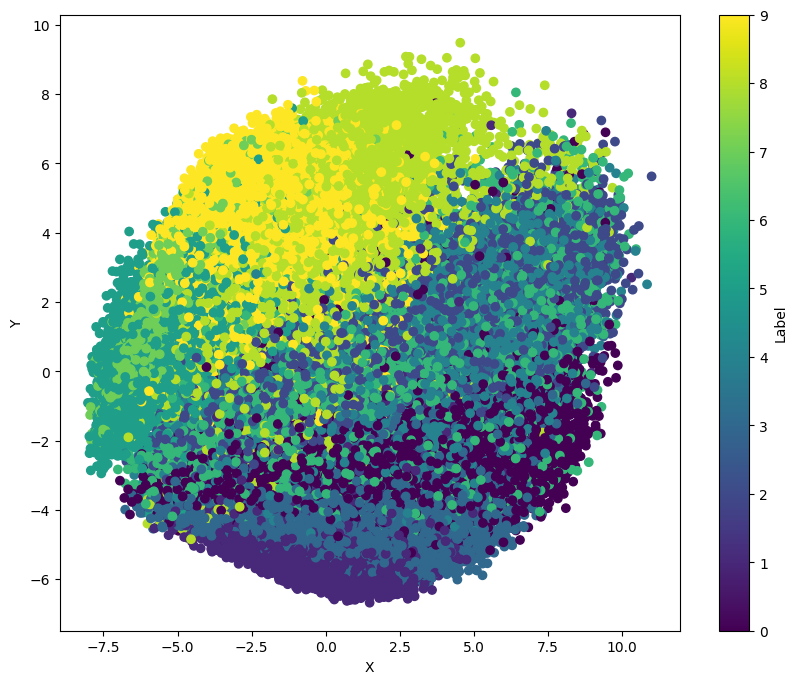

In [ ]:
labels = train_data.targets.numpy()

plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_pca2[:, 0], train_pca2[:, 1], c=labels, cmap='viridis')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(scatter, label='Label')
plt.show()

## T-SNE

### 앞서 pca를 통해 50차원으로 줄인 데이터를 t-sne를 통해 시각화 하세요.

In [ ]:
tsne = TSNE(n_components=2, random_state=0)
train_tsne = tsne.fit_transform(train_pca50)

labels = train_data.targets.numpy()
plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_tsne[:, 0], train_tsne[:, 1], c=labels, cmap='viridis')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(scatter, label='Label')
plt.show()

### 앞서 pca를 통해 30차원으로 줄인 데이터를 t-sne를 통해 시각화 하세요.

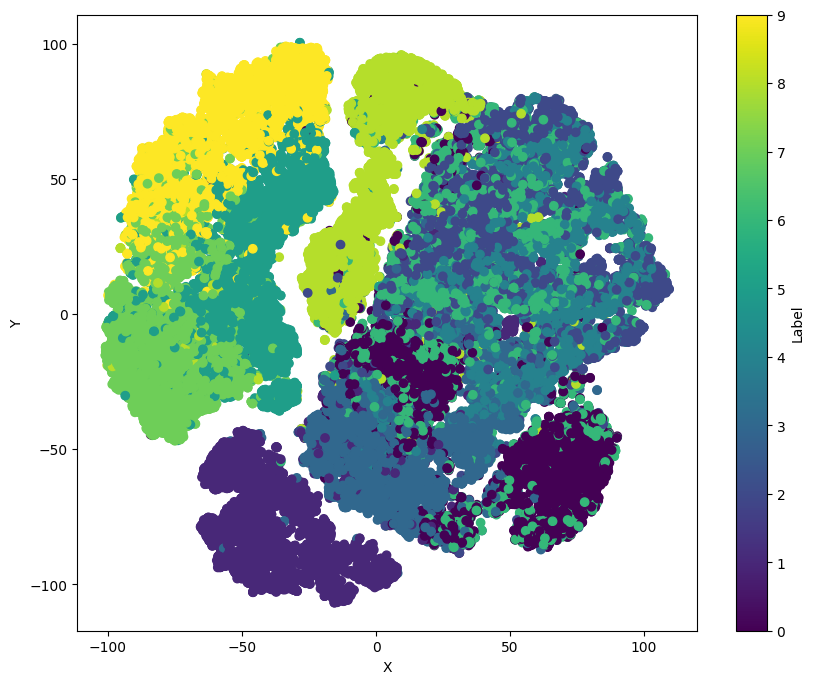

In [ ]:
# t-SNE를 사용하여 2차원으로 축소
tsne = TSNE(n_components=2, random_state=0)
train_tsne = tsne.fit_transform(train_pca30)

# 시각화
labels = train_data.targets.numpy()
plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_tsne[:, 0], train_tsne[:, 1], c=labels, cmap='viridis')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(scatter, label='Label')
plt.show()

## 군집화

### PCA를 통해 50차원으로 줄인 데이터를 DBSCAN을 이용하여 군집화 하시오.

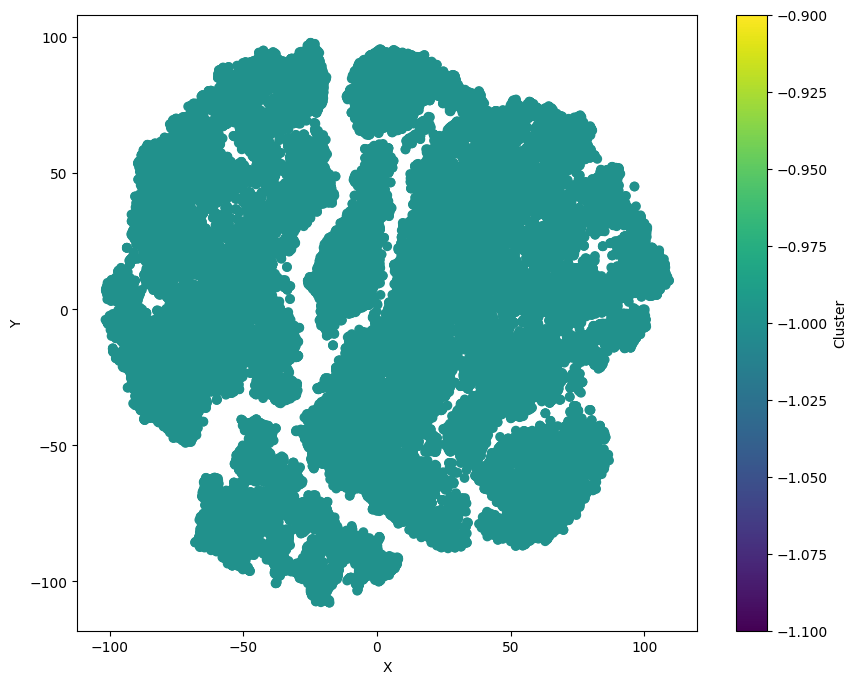

In [ ]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
train_dbscan_labels = dbscan.fit_predict(train_pca50)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_tsne[:, 0], train_tsne[:, 1], c=train_dbscan_labels, cmap='viridis')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(scatter, label='Cluster')
plt.show()

### k-means를 통해 50차원으로 줄인 데이터를 군집화 하시오.(군집의 개수는 10개로 하시오.)

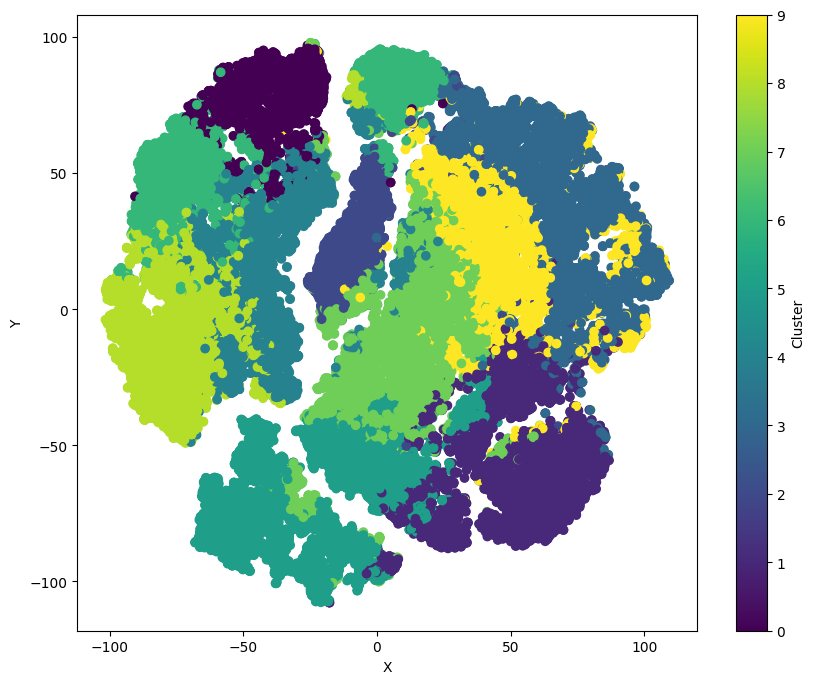

In [ ]:
kmeans = KMeans(n_clusters=10, random_state=0)
train_kmeans_labels = kmeans.fit_predict(train_pca50)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_tsne[:, 0], train_tsne[:, 1], c=train_kmeans_labels, cmap='viridis')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(scatter, label='Cluster')
plt.show()

### 엘보우 메소드를 이용하여 k-means에서 가장 적절한 군집의 개수를 구하시오.

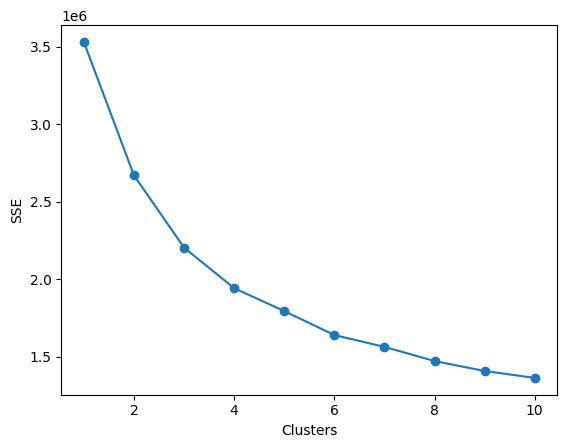

In [ ]:
sse = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(train_pca50)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Clusters')
plt.ylabel('SSE')
plt.show()

팔꿈치 모양으로 급격히 꺾이는 2가 최적의 클러스터 수이다.

### k-means 최적의 군집 개수로 다시 군집화 하여 시각화 하시오.

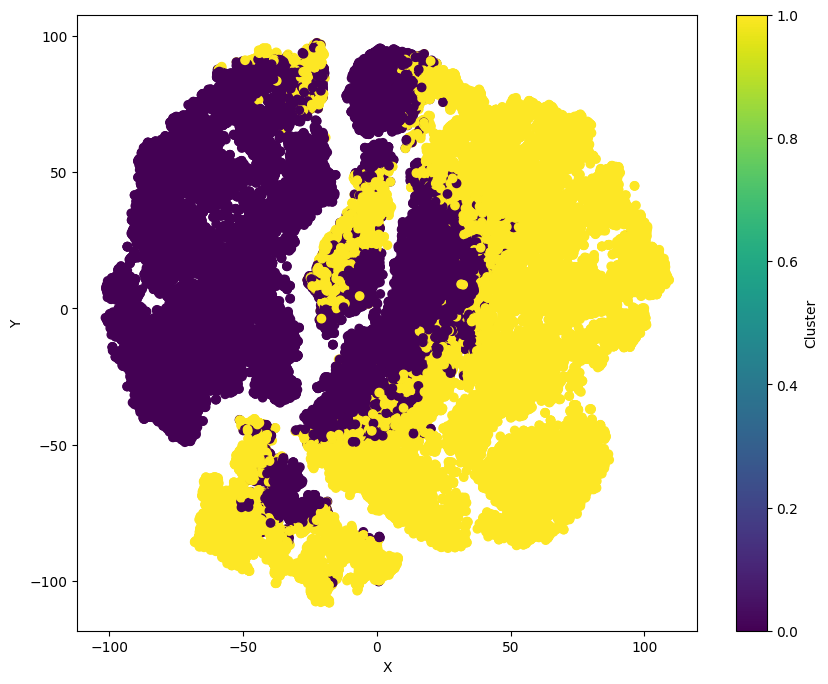

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0)
train_kmeans_labels = kmeans.fit_predict(train_pca50)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_tsne[:, 0], train_tsne[:, 1], c=train_kmeans_labels, cmap='viridis')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(scatter, label='Cluster')
plt.show()

### 다른 추가적인 군집화 기법을 2가지 이상 사용하여 pca 50 데이터를 시각화 하시오.

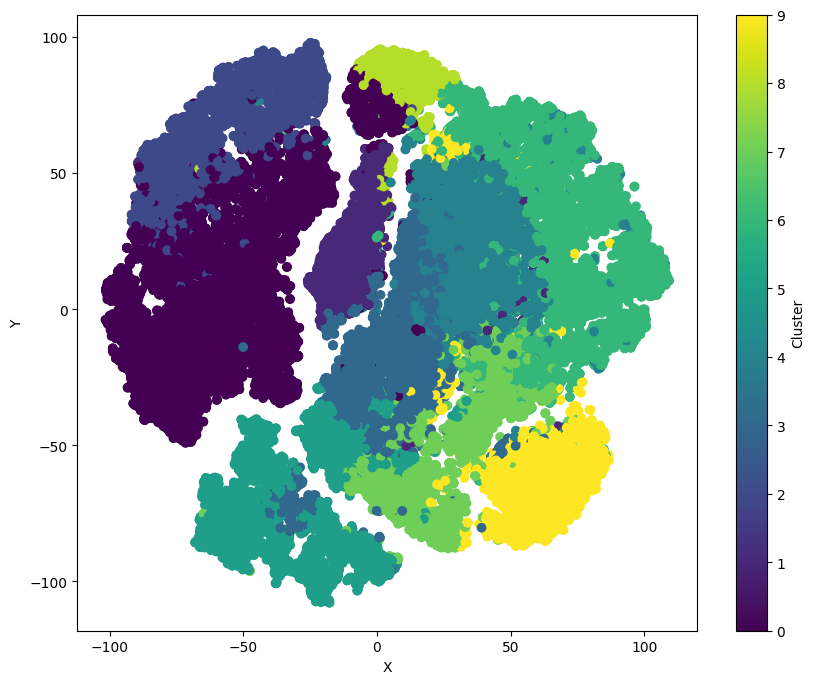

In [ ]:
agg = AgglomerativeClustering(n_clusters=10)
train_agg_labels = agg.fit_predict(train_pca50)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_tsne[:, 0], train_tsne[:, 1], c=train_agg_labels, cmap='viridis')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(scatter, label='Cluster')
plt.show()

In [ ]:
mean_shift = MeanShift()
train_mean_shift_labels = mean_shift.fit_predict(train_pca50)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_tsne[:, 0], train_tsne[:, 1], c=train_mean_shift_labels, cmap='viridis')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(scatter, label='Cluster')
plt.show()

## 군집화 결과 비교

### 앞선 모든 군집화 모델의 결과를 실루엣 점수(Silhouette score)를 이용하여 성능을 비교하시오.

In [ ]:
if len(np.unique(train_dbscan_labels)) > 1:
    db_score = silhouette_score(train_pca50, train_dbscan_labels)
else:
    db_score = -1

if len(np.unique(train_kmeans_labels)) > 1:
    km_score = silhouette_score(train_pca50, train_kmeans_labels)
else:
    km_score = -1

print("db_score: ", db_score)
print("km_score: ", km_score)

db_score:  -1
km_score:  0.17471296251437948


In [ ]:
if len(np.unique(train_agg_labels)) > 1:
    agg_score = silhouette_score(train_pca50, train_agg_labels)
else:
    agg_score = -1

if len(np.unique(train_mean_shift_labels)) > 1:
    ms_score = silhouette_score(train_pca50, train_mean_shift_labels)
else:
    mean_shift_score = -1

print("agg_score: ", agg_score)
print("ms_score: ", ms_score)

### 실루엣 점수를 통해 군집화 모델의 성능에 대한 간단한 해석을 적으세요.

- dbscan은 점수를 계산할 수 없다고 하며, k_means는 0.17로 성능이 좋지 못하다
